# Check the accuracy of offline tracer model, w.r.t. online

In [1]:
clear
homedir = getenv('HOME');
workdir = getenv('WORK');
scradir = getenv('SCRATCH');
campdir = getenv('CAMP');
addpath(genpath([homedir '/work_MOM']));
addpath(genpath([homedir '/mytoolbox']));
addpath(genpath([homedir '/MyFuncs']));

## read tracers

In [2]:
yr_s = 21;
[day_s, day_e, dt_save] = deal(1.0, 365*2, 15);   % 365*4
t_al = day_s:dt_save:day_e;
nt_al = length(t_al);

% ----- exp_cpatch  mom_final_relL_restart
% E_al = { [workdir '/MOM6_exp/exp_cpatch/sol_tr_off/'],...
%          [workdir '/MOM6_exp/exp_cpatch/sol_tr_onl/']};
 E_al = { [campdir '/mom_ptemp/sol_tr_pt_off/'],...
          [campdir '/mom_ptemp/sol_tr_pt/']};
titles = {'offline', 'online'};    
griddir = [workdir '/MOM6_exp/swm_spunup/'];  
[grid, ~, ~] = read_grid_MOM(griddir); % SOLUTION/
nk = length(grid.Layer);

hdir_al = {[campdir '/mom_ptemp/sol_h/'],...
           [campdir '/mom_ptemp/sol_h/'],...
           [campdir '/mom_ptemp/sol_h/']};
ncel = numel(E_al);

In [3]:
%-----------------------

for it = 1:nt_al

    % current time
    t1 = t_al(it);
    [yrstr, dystr, hrstr] = get_timestr(t1, yr_s); % for k and tracer
    
    % read all runs
    for icel = 1:ncel
        c_fnm = [E_al{icel} 'tr__' yrstr '_' dystr '_' hrstr '.nc'];
        h_fnm = [hdir_al{icel} 'h_snap__' yrstr '_' dystr '_' hrstr '.nc'];
        % fnm
        c3d = ncread(c_fnm,'tr1');
        h3d = ncread(h_fnm,'h');
        
        V = squeeze(sum(h3d.* grid.Ah, [1 2],'omitnan'));
        C2V = squeeze(sum(c3d.^2.*h3d.*grid.Ah, [1 2],'omitnan'));
        CV = squeeze(sum(c3d.*h3d.*grid.Ah, [1 2],'omitnan'));

        %
        c_al{icel}(:,:,:,it) = c3d;
        SD{icel}(:,it) = sqrt( C2V./V - (CV./V).^2 );
    end
end

% save([homedir '/work_MOM/data_for_figure/data_S_offonl.mat'],'grid','t_al','c_al','SD','E_al','titles','hdir_al', '-v7.3');


ans =

   16.0560


ans =

   16.0080



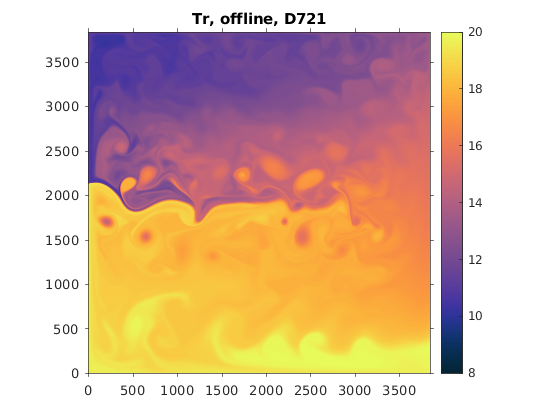

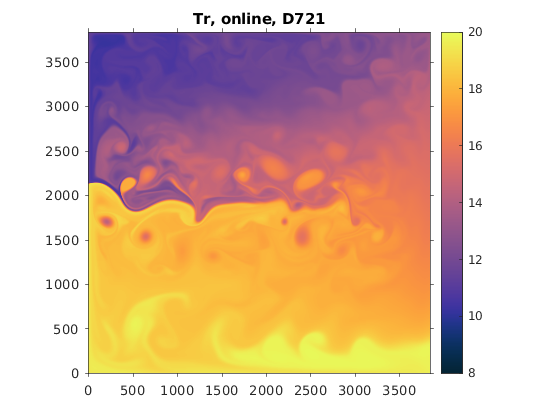

In [4]:
ik = 1;
it = nt_al;
cmap = 'thermal';
clim = [8 20];
win_len = 17;
[x, y] = deal(grid.lonh, grid.lath);
for icel = 1:ncel
    figure
    f_do = c_al{icel}(:,:,ik,it);% 
    
    % f_do = smooth_geom_CG(f_do, grid.dxT.*grid.dyT, win_len, win_len);
    rms(f_do(:))
    imagescn(x, y, f_do'); set(gca,'tickdir','out');%set(gca,'xticklabel','','yticklabel','')
    colorbar; axis square; caxis(clim)
    ax = gca;
    % ax.ColorScale = 'log';
    cmocean(cmap); 
    title(['Tr, ' titles{icel} ', D' num2str(t_al(it),'%3d')] )
end

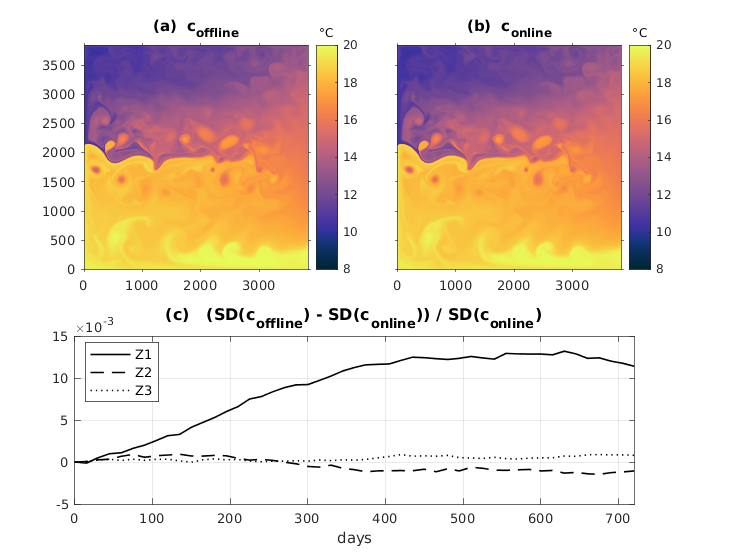

In [5]:
styles = {'k-','k--','k:'};  
titles = {'Z1', 'Z2', 'Z3'};
[x, y] = deal(grid.lonh, grid.lath);

fplt = c_al;
it = nt_al;
ik = 1;

x_top = 0.1; y_top = 0.52; h_top = 0.4; w_top = 0.4; dx_top = 0.02;
x_bot = 0.1; y_bot = 0.1; h_bot = 0.3; w_bot = 0.75; 
pos_top = {[x_top y_top w_top h_top], [x_top+w_top+dx_top y_top w_top h_top]};
pos_bot = [x_bot y_bot w_bot h_bot];


font = 'DejaVu Sans';
figure('DefaultTextFontName', font, 'DefaultAxesFontName', font);

% ----- top
title_al = {'(a)  c_{offline}', '(b)  c_{online}'};
% clim = [1e-6 10e-4]; cmap = 'amp'; 
clim = [8 20]; cmap = 'thermal'; 
% clim = [-1 1]; cmap = 'balance'; 

for icel = 1:2
    ax(icel) = subplot('Position',pos_top{icel});
    % subplot('Position',pos_bot{icel});
    f_do = fplt{icel}(:,:,ik,it);  % - fplt{1}(:,:,1,it)
    imagescn(x, y , f_do'); axis square; set(gca,'tickdir','out'); 
    if icel == 2; set(gca,'yticklabel',''); end
    % set(gca,'ColorScale','log')
    cmocean(cmap); 
    caxis(clim)
    cb = colorbar;
    cb.Title.String = '\circC';
    title( title_al{icel});
    % hdlb(icel+1) = subplotlabel(ax(icel+1),sublabels{icel},'location','northwestoutside','offset',[-0.1 0.01],'fontsize',12);
end

% ----- bot
ax = subplot('Position',pos_bot);
for ik = 1:3
    % subplot(3,1,ik)
    fplt = (SD{1}(ik,:) - SD{2}(ik,:)) ./ SD{2}(ik,:);
    % fplt = SD{icel}(ik,:);
    plot(t_al-t_al(1),fplt,styles{ik},'linewidth',1.2); 
    hold on
    grid on
    set(gca,'XLim',[0 t_al(end)])
    title(['SD at Z' num2str(ik,'%01d')],'fontsize',12)
end
legend(titles,'location','northwest','NumColumns',1,'fontsize',10)
title('(c)   (SD(c_{offline}) - SD(c_{online})) / SD(c_{online})')
xlabel('days')
            
set(gcf,'PaperPositionMode','auto'); 

% ---
fignm = [homedir '/work_MOM/figures/fig_appxC_offonl'];
% exportgraphics(gcf,[fignm '.pdf'], 'BackgroundColor','white','ContentType','vector')